In [17]:
import numpy
import collections
import gym
import matplotlib.pyplot as plt

In [18]:
def get_action( state, q_values, epsilon):
    """
    Select an action from [0,1,2,3] (representing ["Left", "Down", "Right", "Up"] using epsilon-greedy.
    :param state: the state of interest
    :param q_values: a map of q_values.
    :param epsilon: prob of not greedy choice.
    :return: an action
    """
    # Extract the action values.
    action_values = [q_values[(state, 0)], q_values[(state, 1)],q_values[(state, 2)], q_values[(state, 3)]]

    # Then initialize their probabilities as uniform over epsilon.
    action_probs = [epsilon/4, epsilon/4, epsilon/4, epsilon/4]

    # Find the max action value's index, then add (1-epsilon) to its probability.
    maxqsa = max(action_values)

    # if the maximum is 0.0, then all values are still 0.0, therefore force a uniform distribution..
    if maxqsa == 0.0:
        action_probs = [0.25, 0.25, 0.25, 0.25]
    else:
        action = action_values.index(maxqsa)
        action_probs[action] = action_probs[action] + 1-epsilon

    # sample over the probabilities
    return numpy.random.choice([0, 1, 2, 3], p=action_probs )


In [19]:
def get_max_Q(state, q_values):
    """ Given a state, return the max Qvalue among all the actions
    :param state: the state of interest
    :param q_values: a dict with keys as (s,a) and values as q_values.
    :return: max Qvalue among all the actions
    """
    state_action_values = [q_values[(state, 0)], q_values[(state, 1)], q_values[(state, 2)], q_values[(state, 3)]]
    maxQsa = max(state_action_values)
    return maxQsa

In [20]:
def update_ave_rewards(ave_rewards, episode, rewards):
    """
    update ave_rewards array. This array contains a list of successive ave rewards vs num_episodes.
    parameter episode is the index of the ith episode. Therefore its entry will be the average of the (episode-1)th average
    muliplied by (episode-1) then adding rewards, then dividing by episode. Need to figure out zero-indexing.

    :param ave_rewards: a list as described above. The value of  the index is the num of (episodes+1), and the value contains
        the average of rewards across those episodes
    :param episode: the episode index: int
    :param rewards: the scalar reward
    :return: None
    """
    assert episode == len(ave_rewards), "Episode:{} should equal len(ave_rewards):{}".format(episode, len(ave_rewards))
    if episode == 0:
        ave_rewards.append(rewards)
    else:
        reward_sum = ave_rewards[episode-1] * (episode-1)
        reward_sum += rewards
        reward_ave = reward_sum / episode
        ave_rewards.append(reward_ave)


In [21]:
def q_learn(env_name, num_episodes, gamma, alpha, epsilon):
    """

    :param env_name:
    :param num_episodes:
    :param gamma:
    :param alpha:
    :param epsilon:
    :return:
    """

    Q_values = collections.defaultdict(float)  # dict of (state,action):value
    actions = {}  # dict of episode:[actions]
    rewards = {}  # dict of episode: total rewards for tha episode
    ave_rewards = []  # array of  ave rewards across all episodes until episode index
    nonzero_states = []  # array of non-zero states. index is episode.

    env = gym.make(env_name)
    for i_episode in range(num_episodes):
        state = env.reset()  # Initialize S
        actions[i_episode] = []
        rewards[i_episode] = 0.0
        done = False
        while not done:  # Loop until end of episode
            action = get_action(state, Q_values, epsilon)  # Choose A from S using policy (e.g. epsilon-greedy)
            actions[i_episode].append(action)
            newstate, reward, done, info = env.step(action)  # Take action A, observe R, S'
            Q_values[(state, action)] = Q_values[(state, action)] + alpha * (
                    reward + gamma * get_max_Q(newstate, Q_values) - Q_values[(state, action)])
            state = newstate
            rewards[i_episode] += reward

        
        update_ave_rewards(ave_rewards, i_episode, rewards[i_episode])
        if i_episode % 10000 == 0:
            print("Finished episode:{} of {}".format(i_episode, num_episodes))

    return ave_rewards


In [22]:
def sarsa(env_name, num_episodes, gamma, alpha, epsilon):
    """

    :param env_name:
    :param num_episodes:
    :param gamma:
    :param alpha:
    :param epsilon:
    :return:
    """

    actions = {}  # dict of episode:[actions]
    rewards = {}  # dict of episode: total rewards for tha episode
    ave_rewards = []  # array of  ave rewards across all episodes until episode index

    env = gym.make(env_name)

    q_values = collections.defaultdict(float)  # dict of (state,action):value
    for i_episode in range(num_episodes):

        state = env.reset()  # Initialize S
        action = get_action(state, q_values, epsilon)  # Choose A from S using policy (e.g. epsilon-greedy)
        actions[i_episode] = []
        actions[i_episode].append(action)
        rewards[i_episode] = 0.0
        done = False
        while not done:  # Repeat for each step of the episode
            newstate, reward, done, info = env.step(action)  # Take action A, observe R, S'
            newaction = get_action(newstate, q_values, epsilon)  # Choose A' from S' using policy (e.g. epsilon-greedy)
            q_values[(state, action)] = q_values[(state, action)] + alpha * (
                    reward + gamma * q_values[(newstate, newaction)] - q_values[(state, action)])
            state = newstate
            action = newaction
            rewards[i_episode] += reward

        update_ave_rewards(ave_rewards, i_episode, rewards[i_episode])
        if i_episode>0 and i_episode % 1000 == 0:
            print("Finished episode:{} of {}".format(i_episode, num_episodes))

    return ave_rewards


Finished episode:0 of 3000
Finished episode:1000 of 3000
Finished episode:2000 of 3000
Finished episode:0 of 3000
Finished episode:1000 of 3000
Finished episode:2000 of 3000


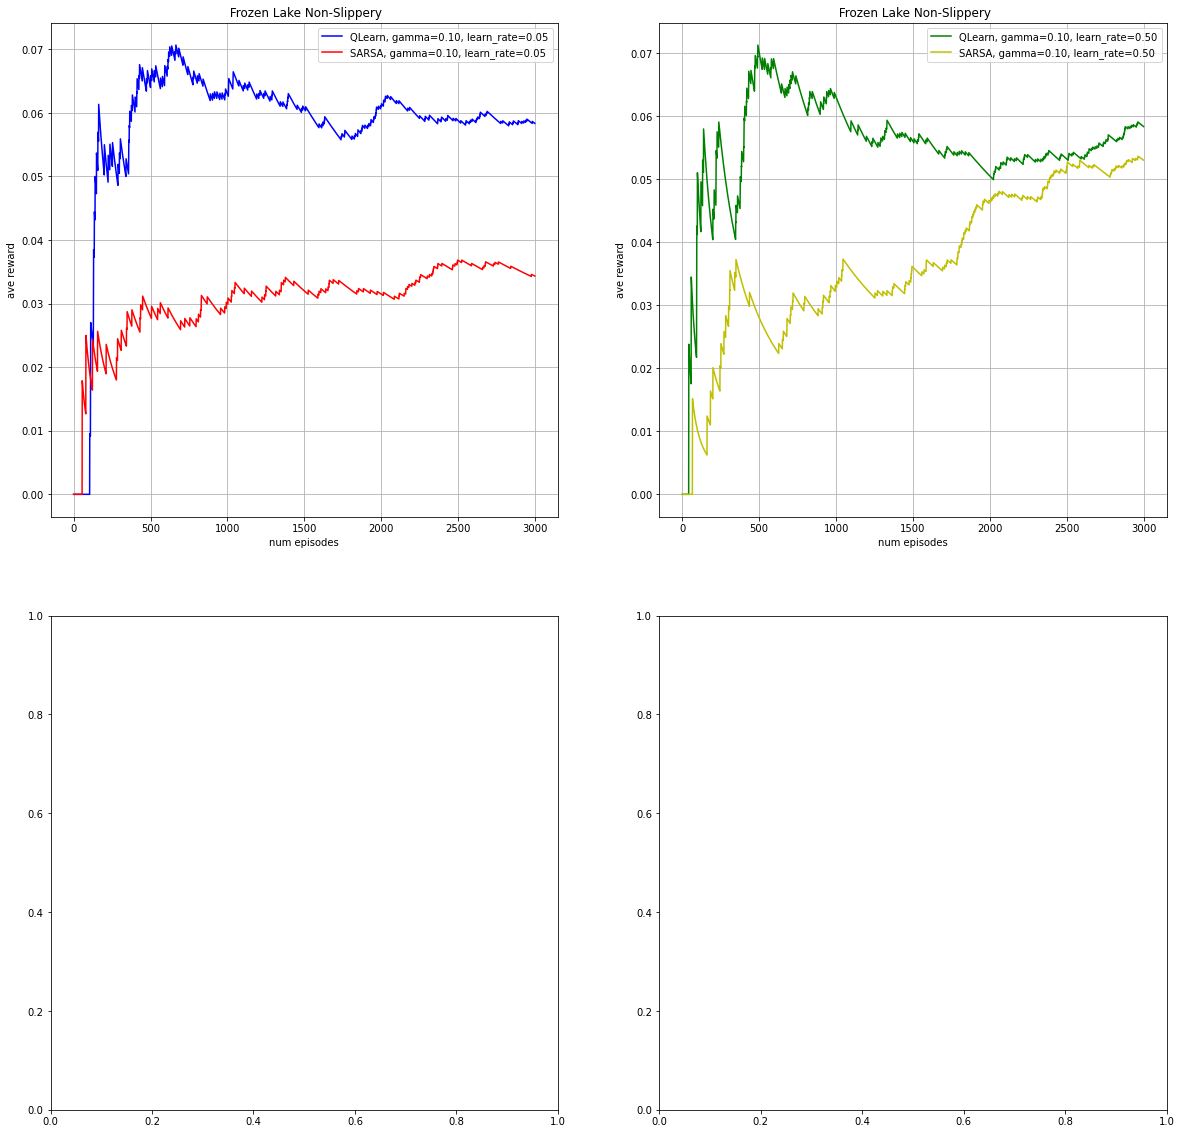

In [23]:
def main():
    env = 'FrozenLake-v0'
    num_episodes = 3000
    epsilon = 0.05
    plt.rcParams['figure.figsize'] = [20, 20]
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
    
    
    gamma = 0.1
    alpha = 0.05
    Q_ave_rewards = q_learn(env, num_episodes, gamma, alpha, epsilon)
    SARSA_ave_rewards = sarsa(env, num_episodes, gamma, alpha, epsilon)
    ax1.plot(Q_ave_rewards, 'b', label='QLearn, gamma=%.2f, learn_rate=%.2f' % (gamma, alpha))
    ax1.plot(SARSA_ave_rewards, 'r', label='SARSA, gamma=%.2f, learn_rate=%.2f'%(gamma, alpha))
    ax1.legend()
    ax1.set(xlabel='num episodes', ylabel='ave reward',
           title=' Frozen Lake Non-Slippery')
    ax1.grid()
    gamma = 0.1
    alpha = 0.50 
    Q_ave_rewards = q_learn(env, num_episodes, gamma, alpha, epsilon)
    SARSA_ave_rewards = sarsa(env, num_episodes, gamma, alpha, epsilon)
    ax2.plot(Q_ave_rewards, 'g', label='QLearn, gamma=%.2f, learn_rate=%.2f'%(gamma, alpha))
    ax2.plot(SARSA_ave_rewards, 'y', label='SARSA, gamma=%.2f, learn_rate=%.2f'%(gamma, alpha))
    ax2.legend()
    ax2.set(xlabel='num episodes', ylabel='ave reward',
           title=' Frozen Lake Non-Slippery')
    ax2.grid()
   
   

    plt.show()
    
if __name__ == "__main__":
    main()